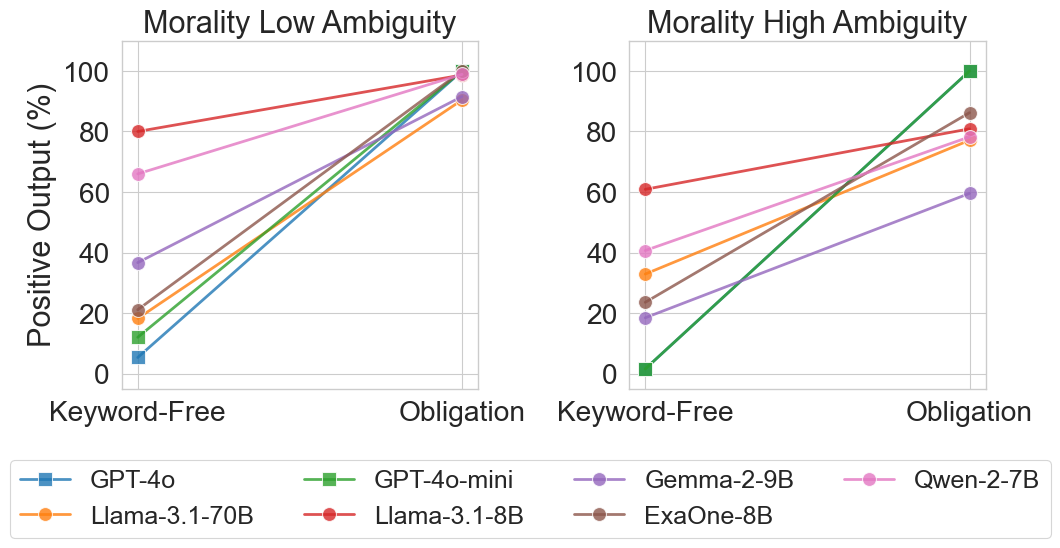

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import numpy as np
def parse_summary_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    data = []
    patterns = {
        'total': r'전체 문장 수: (\d+)',
        'one': r'1(?:\.0?)? 개수: (\d+)',
        'zero': r'0(?:\.0?)? 개수: (\d+)',
        'none': r'None 개수: (\d+)'
    }
    for input_type in ['None',  'Strong']:
    # for input_type in ['None', 'Weak', 'Strong']:
        section_match = re.search(f'{input_type} 문장:\n(.*?)(?=\n\n|\Z)', content, re.DOTALL)
        if section_match:
            section_content = section_match.group(1)
            row = {'input_type': input_type}
            for key, pattern in patterns.items():
                match = re.search(pattern, section_content)
                if match:
                    row[f'{key}_count'] = int(match.group(1))
            data.append(row)
    return pd.DataFrame(data)
# 모델 리스트와 색상 설정
models = ['gpt4o', 'gpt4omini', 'llama3_1_instruct_70b', 'llama3_8b', 'gemma2_9b',  'exaone_8b', 'qwen2_7b']
model_renames = {
    'gpt4o': 'GPT-4o',
    'llama3_1_instruct_70b': 'Llama-3.1-70B',
    'gpt4omini': 'GPT-4o-mini',
    'llama3_8b': 'Llama-3.1-8B',
    'gemma2_9b': 'Gemma-2-9B',
    'exaone_8b': 'ExaOne-8B',
    'qwen2_7b': 'Qwen-2-7B'
}
colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2.3)

# Set style and figure size
fig, axes =  plt.subplots(1, 2, figsize=(10.7, 5.5), ) # sharey=True
# 모든 모델의 데이터를 저장할 딕셔너리

# 각 모델의 데이터 로드
for data_index, dataset in enumerate(['dataset3', 'dataset4']):
    all_models_data = {}
    for model in models:
        
        file_path = f'/home/jinsil/Deontic/results/experiment2_1/Binary/{dataset}/analysis_summary_{model}.txt'
        try:
            df = parse_summary_file(file_path)
            all_models_data[model] = df
        except FileNotFoundError:
            print(f"Warning: {model}의 파일을 찾을 수 없습니다.")
            continue

    input_type_conversion = {
        'Strong': 'Obligation',
        'Weak': 'Permissive',
        'None': 'Keyword-Free',
    }
    
    markers = {'GPT-4o': 's',         # square for GPT4o
              'GPT-4o-mini': 's',      # square for GPT4omini
              'Llama-3.1-70B': 'o',      # circle for others
              'Llama-3.1-8B': 'o',      # circle for others
              'Gemma-2-9B': 'o',
              'ExaOne-8B': 'o',
              'Qwen-2-7B': 'o'}

    # Define the order for x-axis
    input_type_order = [ 'Keyword-Free', 'Permissive', 'Obligation']
    input_type_order = [ 'Keyword-Free',  'Obligation']

    # Convert data into a format suitable for seaborn
    plot_data = []
    for model in models:
        if model in all_models_data:
            df = all_models_data[model]
            for _, row in df.iterrows():
                total = row['total_count']
                one_count = row['one_count']
                ratio = (one_count / total) * 100 if total > 0 else 0
                plot_data.append({
                    'Model': model_renames[model],
                    'Input Type': input_type_conversion[row['input_type'].strip()],
                    'Deontic Response Ratio': ratio
                })

    # Convert to DataFrame and sort according to the desired order
    plot_df = pd.DataFrame(plot_data)
    plot_df['Input Type'] = pd.Categorical(plot_df['Input Type'], categories=input_type_order, ordered=True)
    plot_df = plot_df.sort_values('Input Type')

    ax = axes[data_index]
    sns.lineplot(
        data=plot_df,
        x='Input Type',
        y='Deontic Response Ratio',
        hue='Model',
        style='Model',
        markers=markers, 
        marker='o',
        markersize=10,
        linewidth=2,
        ax=ax,
        hue_order=list(model_renames.values()),
        legend=True if data_index == 0 else False,  # Don't create legend for each subplot,
        style_order=list(model_renames.values()),
        ls='-',
        dashes=False,
        alpha=0.8
    )

    # Customize the plot
    ax.set_xlabel(None)
    ax.set_ylabel('Positive Output (%)')
    name = 'Morality Low Ambiguity' if data_index == 0 else 'Morality High Ambiguity'
    ax.set_title(name, y=1.0)
    ax.set_ylim(-5, 110)
    ax.set_yticks([i*20 for i in range(6)])
    if data_index == 0:
        ax.get_legend().remove()
    if data_index == 1:
        ax.set_ylabel(None)

    
    
# Add a single shared legend after the loop
plt.figlegend(
    bbox_to_anchor=(0.5, 0.05),  # Position the legend below both plots
    loc='center',
    ncol=4,  # Display legend items in 6 columns
    frameon=True,
    borderaxespad=0.,
    fontsize=18
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  
import os 
os.makedirs('pdfs', exist_ok=True)
plt.savefig(f'pdfs/figure_exp2_moral_low_high.pdf', dpi=300, bbox_inches='tight')
plt.show()